<br>

# ResNet Ablation Study

---

In [1]:
# 환경설정

# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow 가 활용할 GPU가 장착되어 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<br>

## ResNet-34 모델

<br>

<br>

### ResNet-34 블록 구성 <br><br>


```block_num``` 은 레이어의 이름을 붙여주기 위해서 추가 <br> 
```input_shape``` 는 summary 를 출력하기 위해서 추가 <br>
```is_first``` 는 ```num_cnn_list``` 의 첫 번째 블록생성인지 확인 <br>
```block_order``` 는 dimensions-increased shortcut 을 적용할 블록인지 확인

<br>

In [3]:
# function for building resnet-34 block

def build_resnet34_block(input_layer,
                    num_cnn=3, 
                    kernel_size=3,
                    strides=1,
                    channel=64,
                    block_num='',
                    is_first=False,
                    block_order=1
                   ):
    # 입력 레이어
    x = input_layer
    # residual stream 을 위해 입력 레이어 카피
    if is_first == False and block_order == 0:
        x_add = keras.layers.Conv2D(
            filters=channel,
            kernel_size=1,
            strides=2,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_x_add'
        )(x)

    else:
        x_add = keras.layers.Conv2D(
            filters=channel,
            kernel_size=1,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_x_add'
        )(x)

    
    if is_first == False and block_order == 0:
        # CNN 레이어1
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=kernel_size,
            strides=2,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv1'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN1'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation1'
        )(x)
    
        # CNN 레이어2 (without activation)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv2'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN2'
        )(x)
    
        # shortcut 레이어 (with activation)
        x = keras.layers.Add(
            name=f'block{block_num}_add_shortcut'
            )([x, x_add])
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN3'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation2'
        )(x)
        
    else:
        # CNN 레이어1
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv1'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN1'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation1'
        )(x)
    
        # CNN 레이어2 (without activation)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv2'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN2'
        )(x)
    
        # shortcut 레이어 (with activation)
        x = keras.layers.Add(
            name=f'block{block_num}_add_shortcut'
            )([x, x_add])
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN3'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation2'
        )(x)
    
    return x

<br>

### ResNet-34 블록 생성 <br><br>

참고. <br>
[tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

<br>

In [4]:
# ResNet-34 Block 생성

resnet_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
resnet_block_output = build_resnet34_block(resnet_input_layer)    # resnet 블록 생성

In [5]:
# 블록 1개 짜리 model 생성

model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)

# 블록 1개의 구성 확인
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block_conv1 (Conv2D)            (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
block_BN1 (BatchNormalization)  (None, 32, 32, 64)   256         block_conv1[0][0]                
__________________________________________________________________________________________________
block_activation1 (Activation)  (None, 32, 32, 64)   0           block_BN1[0][0]                  
_______________________________________________________________________________________

<br>

### ResNet-34 네트워크 모델 구성 <br><br>


블록 내의 'CNN 레이어 수' 와 '채널 수' 는 블록마다 달라집니다. <br>
이는 ResNet-34 과 ResNet-50 에 따라서 같이 변화되므로 함수에 전달되어야 합니다. <br><br>


- config list 인자 설정 : 각 블록 별 'CNN 레이어 수' 와 '채널 수' 를 리스트로 전달 <br>

    ```num_cnn_list=[3,4,6,3]``` <br>
    ```channel_list=[64,128,256,512]```

<br>

In [6]:
# resnet-34 모델을 생성하는 함수 작성

def build_resnet34(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,
              is_50=False):
    
    # 모델을 만들기 전에 config list 들이 같은 길이인지 확인
    assert len(num_cnn_list) == len(channel_list) 
    
    # input 레이어
    input_layer = keras.layers.Input(shape=input_shape)  
    output = input_layer

    # 7x7 conv, 64, /2 레이어
    output = keras.layers.Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        kernel_initializer='he_normal',
        padding='same',
        name='7x7_conv_64_/2'
    )(output)
    output = keras.layers.BatchNormalization(
        name='BN_followed_7x7_conv_64'
    )(output)
    output = tf.keras.layers.Activation(
        'relu',
        name='activation'
    )(output)
    
    # maxpooling 레이어
    output = keras.layers.MaxPooling2D(
        pool_size=(3, 3),
        strides=2,
        padding='same',
        name=f'max_pooling'
    )(output)
    

    count = 0
    # config list 들의 길이만큼 반복해서 Residual 블록을 생성
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
    
        # config list 첫 번째 num_cnn 에 해당하는 residual 블록 생성
        if i == 0:
            for j in range(num_cnn):
                count += 1
                output = build_resnet34_block(
                    output,
                    num_cnn=num_cnn, 
                    channel=channel,
                    block_num=count,
                    is_first=True,
                    block_order=j
                )
                
        # config list 첫 번째 이후의 num_cnn 들에 해당하는 residual 블록 생성
        else:
            for j in range(num_cnn):
                count += 1
                output = build_resnet34_block(
                    output,
                    num_cnn=num_cnn, 
                    channel=channel,
                    block_num=count,
                    is_first=False,
                    block_order=j
                )

    # avg pool 레이어
    output = keras.layers.AveragePooling2D(
        pool_size=(1, 1),
        name='avg_pooling'
    )(output)
    
    # FC 레이어
    output = keras.layers.Flatten(name='flatten')(output)
    # output = keras.layers.Dense(1000, activation='relu', name='fc-1000')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    
    return model

<br>

### ResNet-34 네트워크 모델 생성 <br><br>


생성한 build_resnet34() 함수를 이용해, <br>
손 쉽게 구성(configuration)만 바꾸어 ResNet-34 모델을 생성할 수 있습니다. <br><br>


- config list 인자 설정 : 각 블록 별 'CNN 레이어 수' 와 '채널 수' 를 리스트로 전달 <br>

    ```num_cnn_list=[3,4,6,3]``` <br>
    ```channel_list=[64,128,256,512]```

<br>

In [7]:
# ResNet-34 모델 생성
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16 이 됩니다.

ResNet_34 = build_resnet34()

ResNet_34.summary()

_________________
block6_BN3 (BatchNormalization) (None, 4, 4, 128)    512         block6_add_shortcut[0][0]        
__________________________________________________________________________________________________
block6_activation2 (Activation) (None, 4, 4, 128)    0           block6_BN3[0][0]                 
__________________________________________________________________________________________________
block7_conv1 (Conv2D)           (None, 4, 4, 128)    147584      block6_activation2[0][0]         
__________________________________________________________________________________________________
block7_BN1 (BatchNormalization) (None, 4, 4, 128)    512         block7_conv1[0][0]               
__________________________________________________________________________________________________
block7_activation1 (Activation) (None, 4, 4, 128)    0           block7_BN1[0][0]                 
___________________________________________________________________________________________

<br>

## ResNet-50 모델

<br>

<br>

### ResNet-50 블록 구성 <br><br>


```block_num``` 은 레이어의 이름을 붙여주기 위해서 추가 <br> 
```input_shape``` 는 summary 를 출력하기 위해서 추가 <br>
```is_first``` 는 ```num_cnn_list``` 의 첫 번째 블록생성인지 확인 <br>
```block_order``` 는 dimensions-increased shortcut 을 적용할 블록인지 확인

<br>

In [8]:
# function for building resnet-50 block

def build_resnet50_block(input_layer,
                    num_cnn=3, 
                    kernel_size=3,
                    strides=1,
                    channel=64,
                    block_num='',
                    is_first=False,
                    block_order=1,
                   ):
    # 입력 레이어
    x = input_layer
    
    if is_first == False and block_order == 0:
        # CNN 레이어1
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=1,
            strides=2,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv1'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN1'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation1'
        )(x)
    
        # CNN 레이어2
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv2'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN2'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation2'
        )(x)

        # CNN 레이어3 (without activation)
        x = keras.layers.Conv2D(
            filters=channel*4,
            kernel_size=1,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv3'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN3'
        )(x)
    
        # shortcut 레이어 (with activation)
        x_add = keras.layers.Conv2D(
            filters=channel*4,
            kernel_size=1,
            strides=2,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_x_add'
        )(input_layer)
        x = keras.layers.Add(
            name=f'block{block_num}_add_shortcut'
            )([x, x_add])
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN4'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation3'
        )(x)

    else:
        # CNN 레이어1
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=1,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv1'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN1'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation1'
        )(x)
    
        # CNN 레이어2
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv2'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN2'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation2'
        )(x)

        # CNN 레이어3 (without activation)
        x = keras.layers.Conv2D(
            filters=channel*4,
            kernel_size=1,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv3'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN3'
        )(x)
        
        # shortcut 레이어 (with activation)
        x_add = keras.layers.Conv2D(
            filters=channel*4,
            kernel_size=1,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_x_add'
        )(input_layer)
        x = keras.layers.Add(
            name=f'block{block_num}_add_shortcut'
            )([x, x_add])
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN4'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation3'
        )(x)
    
    return x

<br>

### ResNet-50 블록 생성 <br><br>

참고. <br>
[tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

<br>

In [9]:
# ResNet-50 Block 생성

resnet_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
resnet_block_output = build_resnet50_block(resnet_input_layer)    # resnet 블록 생성

In [10]:
# 블록 1개 짜리 model 생성

model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)

# 블록 1개의 구성 확인
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block_conv1 (Conv2D)            (None, 32, 32, 64)   256         input_3[0][0]                    
__________________________________________________________________________________________________
block_BN1 (BatchNormalization)  (None, 32, 32, 64)   256         block_conv1[0][0]                
__________________________________________________________________________________________________
block_activation1 (Activation)  (None, 32, 32, 64)   0           block_BN1[0][0]                  
_______________________________________________________________________________________

<br>

### ResNet-50 네트워크 모델 구성 <br><br>


블록 내의 'CNN 레이어 수' 와 '채널 수' 는 블록마다 달라집니다. <br>
이는 ResNet-34 과 ResNet-50 에 따라서 같이 변화되므로 함수에 전달되어야 합니다. <br><br>


- config list 인자 설정 : 각 블록 별 'CNN 레이어 수' 와 '채널 수' 를 리스트로 전달 <br>

    ```num_cnn_list=[3,4,6,3]``` <br>
    ```channel_list=[64,128,256,512]```

<br>

In [11]:
# resnet-50 모델을 생성하는 함수 작성

def build_resnet50(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,
              is_50=True):
    
    # 모델을 만들기 전에 config list 들이 같은 길이인지 확인
    assert len(num_cnn_list) == len(channel_list) 
    
    # input 레이어
    input_layer = keras.layers.Input(shape=input_shape)  
    output = input_layer

    # 7x7 conv, 64, /2 레이어
    output = keras.layers.Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        kernel_initializer='he_normal',
        padding='same',
        name='7x7_conv_64_/2'
    )(output)
    output = keras.layers.BatchNormalization(
        name='BN_followed_7x7_conv_64'
    )(output)
    output = tf.keras.layers.Activation(
        'relu',
        name='activation'
    )(output)
    
    # maxpooling 레이어
    output = keras.layers.MaxPooling2D(
        pool_size=(3, 3),
        strides=2,
        padding='same',
        name=f'max_pooling'
    )(output)

    count = 0
    # config list 들의 길이만큼 반복해서 Residual 블록을 생성
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
    
        # config list 첫 번째 num_cnn 에 해당하는 residual 블록 생성
        if i == 0:
            for j in range(num_cnn):
                count += 1
                output = build_resnet50_block(
                    output,
                    num_cnn=num_cnn, 
                    channel=channel,
                    block_num=count,
                    is_first=True,
                    block_order=j
                )
                
        # config list 첫 번째 이후의 num_cnn 들에 해당하는 residual 블록 생성
        else:
            for j in range(num_cnn):
                count += 1
                output = build_resnet50_block(
                    output,
                    num_cnn=num_cnn, 
                    channel=channel,
                    block_num=count,
                    is_first=False,
                    block_order=j
                )

    # avg pool 레이어
    output = keras.layers.AveragePooling2D(
        pool_size=(1, 1),
        name='avg_pooling'
    )(output)
    
    # FC 레이어
    output = keras.layers.Flatten(name='flatten')(output)
    # output = keras.layers.Dense(1000, activation='relu', name='fc-1000')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    
    return model

<br>

### ResNet-50 네트워크 모델 생성 <br><br>


생성한 build_resnet50() 함수를 이용해, <br>
손 쉽게 구성(configuration)만 바꾸어 ResNet-50 모델을 생성할 수 있습니다. <br><br>


- config list 인자 설정 : 각 블록 별 'CNN 레이어 수' 와 '채널 수' 를 리스트로 전달 <br>

    ```num_cnn_list=[3,4,6,3]``` <br>
    ```channel_list=[64,128,256,512]```

<br>

In [12]:
# ResNet-50 모델 생성
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.

ResNet_50 = build_resnet50(
    num_cnn_list=[3,4,6,3],
    channel_list=[64,128,256,512]
)

ResNet_50.summary()

_________________
block9_conv2 (Conv2D)           (None, 2, 2, 256)    590080      block9_activation1[0][0]         
__________________________________________________________________________________________________
block9_BN2 (BatchNormalization) (None, 2, 2, 256)    1024        block9_conv2[0][0]               
__________________________________________________________________________________________________
block9_activation2 (Activation) (None, 2, 2, 256)    0           block9_BN2[0][0]                 
__________________________________________________________________________________________________
block9_conv3 (Conv2D)           (None, 2, 2, 1024)   263168      block9_activation2[0][0]         
__________________________________________________________________________________________________
block9_BN3 (BatchNormalization) (None, 2, 2, 1024)   4096        block9_conv3[0][0]               
___________________________________________________________________________________________

<br>

## PlainNet-34 모델

<br>

<br>

### PlainNet-34 블록 구성 <br><br>


```block_num``` 은 레이어의 이름을 붙여주기 위해서 추가 <br> 
```input_shape``` 는 summary 를 출력하기 위해서 추가 <br>
```is_first``` 는 ```num_cnn_list``` 의 첫 번째 블록생성인지 확인 <br>
```block_order``` 는 dimensions-increased shortcut 을 적용할 블록인지 확인

<br>

In [13]:
# function for building PlainNet-34 block

def build_plain34_block(input_layer,
                    num_cnn=3, 
                    kernel_size=3,
                    strides=1,
                    channel=64,
                    block_num='',
                    is_first=False,
                    block_order=1
                   ):
    # 입력 레이어
    x = input_layer
    
    if is_first == False and block_order == 0:
        # CNN 레이어1
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=kernel_size,
            strides=2,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv1'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN1'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation1'
        )(x)
    
        # CNN 레이어2 (without activation)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv2'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN2'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation2'
        )(x)
        
    else:
        # CNN 레이어1
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv1'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN1'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation1'
        )(x)
    
        # CNN 레이어2 (without activation)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv2'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN2'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation2'
        )(x)
    
    return x

<br>

### PlainNet-34 블록 생성 <br><br>

참고. <br>
[tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

<br>

In [14]:
# PlainNet-34 Block 생성

plain_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
plain_block_output = build_plain34_block(plain_input_layer)    # plain 블록 생성

In [15]:
# 블록 1개 짜리 model 생성

model = keras.Model(inputs=plain_input_layer, outputs=plain_block_output)

# 블록 1개의 구성 확인
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block_conv1 (Conv2D)         (None, 32, 32, 64)        1792      
_________________________________________________________________
block_BN1 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
block_activation1 (Activatio (None, 32, 32, 64)        0         
_________________________________________________________________
block_conv2 (Conv2D)         (None, 32, 32, 64)        36928     
_________________________________________________________________
block_BN2 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
block_activation2 (Activatio (None, 32, 32, 64)       

<br>

### PlainNet-34 네트워크 모델 구성 <br><br>


- config list 인자 설정 : 각 블록 별 'CNN 레이어 수' 와 '채널 수' 를 리스트로 전달 <br>

    ```num_cnn_list=[3,4,6,3]``` <br>
    ```channel_list=[64,128,256,512]```

<br>

In [16]:
# PlainNet-34 모델을 생성하는 함수 작성

def build_plain34(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,
              is_50=False):
    
    # 모델을 만들기 전에 config list 들이 같은 길이인지 확인
    assert len(num_cnn_list) == len(channel_list) 
    
    # input 레이어
    input_layer = keras.layers.Input(shape=input_shape)  
    output = input_layer

    # 7x7 conv, 64, /2 레이어
    output = keras.layers.Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        kernel_initializer='he_normal',
        padding='same',
        name='7x7_conv_64_/2'
    )(output)
    output = keras.layers.BatchNormalization(
        name='BN_followed_7x7_conv_64'
    )(output)
    output = tf.keras.layers.Activation(
        'relu',
        name='activation'
    )(output)
    
    # maxpooling 레이어
    output = keras.layers.MaxPooling2D(
        pool_size=(3, 3),
        strides=2,
        padding='same',
        name=f'max_pooling'
    )(output)
    

    count = 0
    # config list 들의 길이만큼 반복해서 Residual 블록을 생성
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
    
        # config list 첫 번째 num_cnn 에 해당하는 residual 블록 생성
        if i == 0:
            for j in range(num_cnn):
                count += 1
                output = build_plain34_block(
                    output,
                    num_cnn=num_cnn, 
                    channel=channel,
                    block_num=count,
                    is_first=True,
                    block_order=j
                )
                
        # config list 첫 번째 이후의 num_cnn 들에 해당하는 residual 블록 생성
        else:
            for j in range(num_cnn):
                count += 1
                output = build_plain34_block(
                    output,
                    num_cnn=num_cnn, 
                    channel=channel,
                    block_num=count,
                    is_first=False,
                    block_order=j
                )

    # avg pool 레이어
    output = keras.layers.AveragePooling2D(
        pool_size=(1, 1),
        name='avg_pooling'
    )(output)
    
    # FC 레이어
    output = keras.layers.Flatten(name='flatten')(output)
    # output = keras.layers.Dense(1000, activation='relu', name='fc-1000')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    
    return model

In [17]:
# PlainNet-34 모델 생성

PlainNet_34 = build_plain34()

PlainNet_34.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
7x7_conv_64_/2 (Conv2D)      (None, 16, 16, 64)        9472      
_________________________________________________________________
BN_followed_7x7_conv_64 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling (MaxPooling2D)   (None, 8, 8, 64)          0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 8, 8, 64)          36928     
_________________________________________________________________
block1_BN1 (BatchNormalizati (None, 8, 8, 64)        

<br>

## PlainNet-50 모델

<br>

<br>

### PlainNet-50 블록 구성 <br><br>


```block_num``` 은 레이어의 이름을 붙여주기 위해서 추가 <br> 
```input_shape``` 는 summary 를 출력하기 위해서 추가 <br>
```is_first``` 는 ```num_cnn_list``` 의 첫 번째 블록생성인지 확인 <br>
```block_order``` 는 dimensions-increased shortcut 을 적용할 블록인지 확인

<br>

In [18]:
# function for building PlainNet-50 block

def build_plain50_block(input_layer,
                    num_cnn=3, 
                    kernel_size=3,
                    strides=1,
                    channel=64,
                    block_num='',
                    is_first=False,
                    block_order=1,
                   ):
    # 입력 레이어
    x = input_layer
    
    if is_first == False and block_order == 0:
        # CNN 레이어1
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=1,
            strides=2,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv1'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN1'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation1'
        )(x)
    
        # CNN 레이어2
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv2'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN2'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation2'
        )(x)

        # CNN 레이어3 (without activation)
        x = keras.layers.Conv2D(
            filters=channel*4,
            kernel_size=1,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv3'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN3'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation3'
        )(x)

    else:
        # CNN 레이어1
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=1,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv1'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN1'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation1'
        )(x)
    
        # CNN 레이어2
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv2'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN2'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation2'
        )(x)

        # CNN 레이어3 (without activation)
        x = keras.layers.Conv2D(
            filters=channel*4,
            kernel_size=1,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv3'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_BN3'
        )(x)
        x = tf.keras.layers.Activation(
            'relu',
            name=f'block{block_num}_activation3'
        )(x)
    
    return x

<br>

### PlainNet-50 블록 생성 <br><br>

참고. <br>
[tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

<br>

In [19]:
# PlainNet-50 Block 생성

plain_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
plain_block_output = build_plain50_block(plain_input_layer)    # plain 블록 생성

In [20]:
# 블록 1개 짜리 model 생성

model = keras.Model(inputs=plain_input_layer, outputs=plain_block_output)

# 블록 1개의 구성 확인
model.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block_conv1 (Conv2D)         (None, 32, 32, 64)        256       
_________________________________________________________________
block_BN1 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
block_activation1 (Activatio (None, 32, 32, 64)        0         
_________________________________________________________________
block_conv2 (Conv2D)         (None, 32, 32, 64)        36928     
_________________________________________________________________
block_BN2 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
block_activation2 (Activatio (None, 32, 32, 64)      

<br>

### PlainNet-50 네트워크 모델 구성 <br><br>


- config list 인자 설정 : 각 블록 별 'CNN 레이어 수' 와 '채널 수' 를 리스트로 전달 <br>

    ```num_cnn_list=[3,4,6,3]``` <br>
    ```channel_list=[64,128,256,512]```

<br>

In [21]:
# PlainNet-50 모델을 생성하는 함수 작성

def build_plain50(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,
              is_50=False):
    
    # 모델을 만들기 전에 config list 들이 같은 길이인지 확인
    assert len(num_cnn_list) == len(channel_list) 
    
    # input 레이어
    input_layer = keras.layers.Input(shape=input_shape)  
    output = input_layer

    # 7x7 conv, 64, /2 레이어
    output = keras.layers.Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        kernel_initializer='he_normal',
        padding='same',
        name='7x7_conv_64_/2'
    )(output)
    output = keras.layers.BatchNormalization(
        name='BN_followed_7x7_conv_64'
    )(output)
    output = tf.keras.layers.Activation(
        'relu',
        name='activation'
    )(output)
    
    # maxpooling 레이어
    output = keras.layers.MaxPooling2D(
        pool_size=(3, 3),
        strides=2,
        padding='same',
        name=f'max_pooling'
    )(output)
    

    count = 0
    # config list 들의 길이만큼 반복해서 Residual 블록을 생성
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
    
        # config list 첫 번째 num_cnn 에 해당하는 residual 블록 생성
        if i == 0:
            for j in range(num_cnn):
                count += 1
                output = build_plain50_block(
                    output,
                    num_cnn=num_cnn, 
                    channel=channel,
                    block_num=count,
                    is_first=True,
                    block_order=j
                )
                
        # config list 첫 번째 이후의 num_cnn 들에 해당하는 residual 블록 생성
        else:
            for j in range(num_cnn):
                count += 1
                output = build_plain50_block(
                    output,
                    num_cnn=num_cnn, 
                    channel=channel,
                    block_num=count,
                    is_first=False,
                    block_order=j
                )

    # avg pool 레이어
    output = keras.layers.AveragePooling2D(
        pool_size=(1, 1),
        name='avg_pooling'
    )(output)
    
    # FC 레이어
    output = keras.layers.Flatten(name='flatten')(output)
    # output = keras.layers.Dense(1000, activation='relu', name='fc-1000')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    
    return model

In [22]:
# PlainNet-50 모델 생성

PlainNet_50 = build_plain50()

PlainNet_50.summary()

__________________________________________________
BN_followed_7x7_conv_64 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling (MaxPooling2D)   (None, 8, 8, 64)          0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 8, 8, 64)          4160      
_________________________________________________________________
block1_BN1 (BatchNormalizati (None, 8, 8, 64)          256       
_________________________________________________________________
block1_activation1 (Activati (None, 8, 8, 64)          0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 8, 8, 64)          36928     
_________________________________________________________________
block1_BN2 (BatchNormaliz

<br>

# 개 고양이 판별 모델 성능 비교

<br>

<br>

## Dataset 준비 <br><br>


[CIFAR-10 from Tensorflow dataset](https://www.tensorflow.org/datasets/catalog/cifar10) <br><br>

```
pip install tensorflow-datasets
```
<br>


참고. <br>
[DatasetBuilder](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) <br>

- ```tfds.load()``` 를 통해 데이터를 불러온 뒤, <br>
    DatasetBuilder 의 info 를 통해 정보를 확인 <br><br>

- tfds.load() 의 데이터 저장 경로 <br>
    기본적으로 ```~/tensorflow_datasets``` 경로에 데이터셋을 다운로드 <br><br>
    
    데이터셋 크기가 커서 하나의 폴더에 모아놓고 사용하는 것도 좋은 방법이므로, <br>
    ```~/aiffel``` 프로젝트 폴더가 아닌 기본 경로에 다운 받아 사용 가능 <br>
    (데이터셋 경로를 바꾸고 싶으면, ```data_dir``` 인자 사용)

<br>

In [24]:
# 데이터셋 생성

directory = os.getenv('HOME')+'/aiffel/Going_Deeper/02_ResNet_Ablation_Study'

image_size = (180, 180)
input_shape = (180, 180, 3)
batch_size = 256

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory+'/data/PetImages',
    labels='inferred',
    validation_split=0.2,
    subset="training",
    seed=99,
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory+'/data/PetImages',
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    seed=99,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [25]:
# 데이터 확인
# 배치사이즈로 나누어진 데이터 정보

# (img, label) 형태의 튜플 형식으로 저장된 데이터
print(train_ds)
print(test_ds)

print(tf.data.experimental.cardinality(train_ds))
print(tf.data.experimental.cardinality(test_ds))

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>
tf.Tensor(74, shape=(), dtype=int64)
tf.Tensor(19, shape=(), dtype=int64)


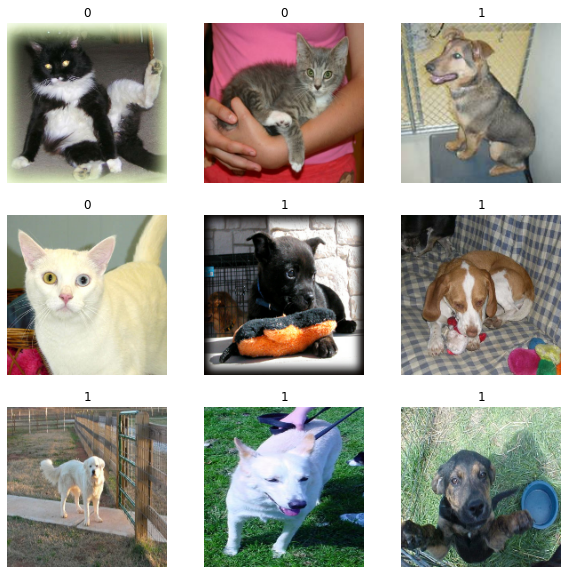

In [26]:
# 데이터 샘플 확인

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


<br>

### Input Normalization <br><br>

보통 RGB 이미지 데이터는 <br> 
\[가로 x 세로 x 채널\] 형태의 행렬 안의 각 픽셀들에 0 ~ 255 사이 값들이 들어가 있습니다. <br>

데이터셋을 모델에 넣어주기 전에 각 채널별 최대값인 255 로 정규화(Normalize) 해주어 <br>
이미지의 표현이 0 ~ 1 사이 값으로 들어가도록 만들어줍니다. <br><br>


참고. <br>
[정규화(Normalization)](https://light-tree.tistory.com/132)

<br>

In [27]:
# 데이터를 normalize 와 resize 해주는 함수 작성

# Normalizes images : `uint8` -> `float32`
def normalize_and_resize_img(image, label):
    
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [28]:
# 데이터셋 전체에 대해 위 normalize 함수 적용해주는 함수 작성

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(99)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

<br>

## 학습용 모델 생성

<br>

In [29]:
# ResNet-34

# ResNet-34 Block 생성
resnet_input_layer = keras.layers.Input(shape=input_shape)   # 입력 레이어 생성
resnet_block_output = build_resnet34_block(resnet_input_layer)    # resnet 블록 생성

# ResNet-34 모델 생성
ResNet_34 = build_resnet34(input_shape=input_shape)

In [30]:
# ResNet-50

# ResNet-50 Block 생성
resnet_input_layer = keras.layers.Input(shape=input_shape)   # 입력 레이어 생성
resnet_block_output = build_resnet50_block(resnet_input_layer)    # resnet 블록 생성

# ResNet-50 모델 생성
ResNet_50 = build_resnet50(input_shape=input_shape)

In [31]:
# PlainNet-34

# PlainNet-34 Block 생성
plain_input_layer = keras.layers.Input(shape=input_shape)   # 입력 레이어 생성
plain_block_output = build_plain34_block(plain_input_layer)    # plain 블록 생성

# PlainNet-34 모델 생성
PlainNet_34 = build_plain34(input_shape=input_shape)


In [32]:
# PlainNet-50

# PlainNet-50 Block 생성

plain_input_layer = keras.layers.Input(shape=input_shape)   # 입력 레이어 생성
plain_block_output = build_plain50_block(plain_input_layer)    # plain 블록 생성

# PlainNet-50 모델 생성
PlainNet_50 = build_plain50(input_shape)

<br>

## 모델 학습

<br>

In [33]:
# 하이퍼파라미터 설정

EPOCHS = 10
BATCH_SIZE = 256
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
wd = 0.0001
momentum = 0.9

In [34]:
# 데이터셋 준비

"""
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:90%]', 'train[90%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
"""

ds_train = apply_normalize_on_dataset(train_ds, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(test_ds, is_test=True, batch_size=BATCH_SIZE)

In [35]:
print(ds_train)
print(ds_test)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>
<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


In [36]:
# checkpoint 생성

checkpoint_filepath = directory + '/model_checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


<br>

### ResNet-34 모델 학습

<br>

In [37]:
# ResNet-34 모델 컴파일
# optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.)

ResNet_34.compile(
    loss='binary_crossentropy', 
    optimizer=tfa.optimizers.SGDW(learning_rate=lr, weight_decay=wd, momentum=momentum), 
    metrics=['accuracy'])

In [42]:
history_resnet34 = ResNet_34.fit(
    x=ds_train,
    steps_per_epoch=int(tf.data.experimental.cardinality(train_ds)),
    validation_steps=int(tf.data.experimental.cardinality(test_ds)),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10


TypeError: 'NoneType' object is not callable